<a href="https://colab.research.google.com/github/nfaggian/record_linkage/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Record linkage : Clustering

In [1]:
%%capture dependency_log
!pip install jellyfish tqdm matplotlib

In [16]:
import numpy as np
import pandas as pd
import tqdm
import uuid
import jellyfish as jf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from IPython.display import HTML, display, clear_output

## GCP authentication
- - - 

In [3]:
try: 
    from google.colab import auth
    auth.authenticate_user()
except:     
    try:
        import google.auth
        credentials, project = google.auth.default()
    except:
        raise Exception('Google cloud authentication required!')

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
%env GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian

project_id = 'anz-pso-nfaggian'

env: GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian


## Retrieve donor and contributions data

In [5]:
query = f"""
SELECT
  * 
FROM
  dedup.donors
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 1000) = 0
"""

raw_donors = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
raw_donors = raw_donors.sort_values(by='donor_id')
print(raw_donors.shape)
raw_donors.head()

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(726, 10)


,donor_id,last_name,first_name,address_1,address_2,city,state,zip,employer,occupation
220,404,1-28-07 cash deposits,None,None,None,None,il,None,None,None
548,422,12 congressional district afl-cio cope cont. fund,None,59 magnolia dr.,None,belleville,il,62221,None,None
295,616,1420 west lexington partnership,None,1420 west lexington partnership,None,chicago,il,60607,None,None
309,988,18th ward democratic org,None,8150 s kedzie ave,None,chicago,il,60652,None,None
300,2158,35th & indiana currency exchange,None,126 e. 35th street,None,chicago,il,60616,None,None


In [6]:
query = f"""
SELECT
  donor_id, amount
FROM
  dedup.contributions
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 1000) = 0
"""

raw_donations = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
raw_donations = raw_donations.sort_values(by='donor_id')
raw_donations.head()

,donor_id,amount
858,404,129.0
1141,422,300.0
1477,616,600.0
346,988,200.0
1650,2158,500.0


**Data preperation**
- - - 

In [7]:
def transform(record):
  """
  Perform some simple transformations on the record.
  """
  
  # combine the first and last name
  return {
      'donor_id': record.donor_id,
          'city': f"{record.city or ' '}".strip().lower(),
          'name': f"{record.first_name or ' '} {record.last_name or ' '}".strip().lower(),
       'address': f"{record.address_1 or ' '} {record.address_2 or ' '}".strip().lower(), 
         'state': f"{record.state or ' '}".strip().lower(),
           'zip': f"{record.zip or ' '}".strip().lower(),
    'occupation': f"{record.occupation or ' '}".strip().lower(),
      'employer': f"{record.employer or ' '}".strip().lower(),
     'is_person': record.first_name is not None }

In [8]:
donors = [] 
for row, record in tqdm.tqdm(raw_donors.iterrows(), total=raw_donors.shape[0]):
    donors.append(transform(record))
donors = pd.DataFrame(donors)
donors.head()

100%|██████████| 726/726 [00:00<00:00, 2255.97it/s]


,address,city,donor_id,employer,is_person,name,occupation,state,zip
0,,,404,,False,1-28-07 cash deposits,,il,
1,59 magnolia dr.,belleville,422,,False,12 congressional district afl-cio cope cont. fund,,il,62221
2,1420 west lexington partnership,chicago,616,,False,1420 west lexington partnership,,il,60607
3,8150 s kedzie ave,chicago,988,,False,18th ward democratic org,,il,60652
4,126 e. 35th street,chicago,2158,,False,35th & indiana currency exchange,,il,60616


## Comparing duplicated donor data
- - -

In [356]:
def comparator(record_a, record_b):
  """
  Compares one field to another, using a series of distance metrics.
  """  
  return {
    'donor_id1': record_a.donor_id,
    'donor_id2': record_b.donor_id,
    # name
    'jaro_name': jf.jaro_winkler(record_a['name'], record_b['name']),
    'phonetic_name': jf.match_rating_comparison(record_a['name'], record_b['name']),
    'damerau_name': jf.damerau_levenshtein_distance(record_a['name'], record_b['name']),
    # address  
    'jaro_address': jf.jaro_winkler(record_a['address'], record_b['address']),
    'phonetic_address': jf.match_rating_comparison(record_a['address'], record_b['address']),  
    'damerau_address': jf.damerau_levenshtein_distance(record_a['address'], record_b['address']),  
   }


In [357]:
distance_table = []
for row_a, record_a in tqdm.tqdm(donors.iterrows(), total=donors.shape[0]):
      for row_b, record_b in donors.iterrows():
            if row_a == row_b: continue    
            distance_table.append(comparator(record_a, record_b)) 
distance_table = pd.DataFrame(distance_table)

100%|██████████| 726/726 [05:06<00:00,  2.61it/s]


In [358]:
distance_table = distance_table.sort_values(by='jaro_name', ascending=False)

In [360]:
def classifier(record):
       """
    Simple voting classifier.
    * assumes an equal weighting for the different types of distance metrics. 
    """
    votes = [
        record['jaro_name'] > 0.67258,
        record['jaro_address'] > 0.7111,
        record['damerau_name'] < 9,
        record['damerau_address'] < 9]
    return np.mean(votes)    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [ ]:
classification_column = []
for row, record in tqdm.tqdm(distance_table.iterrows(), total=distance_table.shape[0]):
    classification_column.append(baseline_classifier(record))

In [ ]:
distance_table['duplicate_score'] = np.array(classification_column)

## Clustering
- - -

Using a hierachical clustering algorithm we can form a distinct set of clustered records. 

In [299]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

In [323]:
distance_matrix = distance_table.pivot('donor_id1', 'donor_id2', 'duplicate_score')
distance_matrix[distance_matrix.isnull()] = 1.0
distance_matrix = 1 - distance_matrix

In [353]:
Z = linkage(squareform(distance_matrix), method='ward', metric='euclidean')

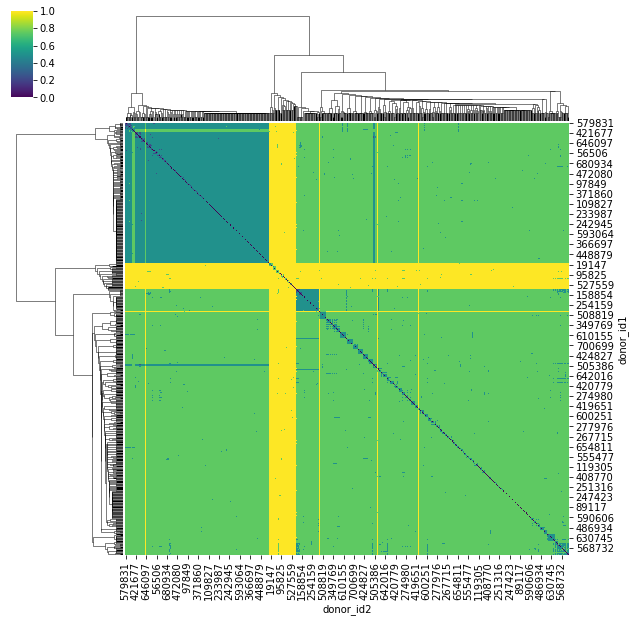

In [355]:
sns.clustermap(distance_matrix, row_linkage=Z, col_linkage=Z, figsize=(10, 10), cmap='viridis');

Using **fcluster** we can form flat clusters from the heirachical clustering (above), We use the "cophenetic" distance threshold of 0.1 to form clusters.

In [347]:
clusters = fcluster(Z, 0.1, criterion='distance')

In [348]:
cluster_table = pd.DataFrame(np.c_[[distance_matrix.index.values, clusters]].transpose(), 
                             columns=['donor_id', 'cluster_id']) 

cluster_table.head()

,donor_id,cluster_id
0,404,598
1,422,667
2,616,110
3,988,108
4,2158,72


After forming a new identifier for clusters we can add them to the donor and donation tables.

In [349]:
donor_map = {a:b for a, b in zip(cluster_table.donor_id, cluster_table.cluster_id)}

raw_donations['cluster_id'] = raw_donations['donor_id'].apply(lambda x: donor_map[x])

donors['cluster_id'] = donors['donor_id'].apply(lambda x: donor_map[x])

Using the **cluster identifier** we can now start to look at donations from the same linked individual, for example if we look at records where total donations exceeded $10,000 and records have been linked:

In [350]:
for cluster, frame in raw_donations.groupby('cluster_id'):
    if (frame.amount.sum() > 10000) & (len(frame.donor_id.unique()) > 1):
        display(HTML('<hr>'))
        display(HTML(f'<h4>Totoal donations: ${frame.amount.sum()}</h4>'))
        display(frame)
        display(HTML(f'<h4>Linked records: <h4>'))
        display(donors[donors.cluster_id == cluster])  

,donor_id,amount,cluster_id
1307,59353,5000.0,50
1095,59353,250.0,50
1118,59353,1000.0,50
1093,59353,15000.0,50
1246,59353,1000.0,50
1150,59441,5000.0,50
529,59441,5000.0,50
1075,59441,5000.0,50
1078,59441,10000.0,50
492,59441,5000.0,50


,address,city,donor_id,employer,is_person,name,occupation,state,zip,cluster_id
61,12 e. erie street,chicago,59353,,False,chicago & ne ii dist. council carpenters,,il,62611,50
62,12 e. erie street,chicago,59441,,False,chicago & northeast il dist - carpenters pac,,il,60611,50


,donor_id,amount,cluster_id
938,506010,2500.0,61
1308,506010,700.0,61
1521,506010,700.0,61
811,506010,650.0,61
616,506010,700.0,61
1286,506010,1250.0,61
1427,506010,700.0,61
70,506010,500.0,61
715,506010,650.0,61
1184,506010,700.0,61


,address,city,donor_id,employer,is_person,name,occupation,state,zip,cluster_id
521,2 n. lasalle,chicago,506010,crane & norcross,True,john norcross,attorney,il,60602,61
522,2 n lasalle suite 2000,chicago,506047,,True,"john norcross,",,il,60602,61


,donor_id,amount,cluster_id
888,119305,450.0,583
1452,119314,1400.0,583
1309,119314,1000.0,583
1414,119314,250.0,583
1292,119314,5000.0,583
1432,119314,5000.0,583
1431,119314,1000.0,583
1186,119314,4000.0,583


,address,city,donor_id,employer,is_person,name,occupation,state,zip,cluster_id
126,825 midway drive,wilowbrook,119305,,False,frank novotny & associates,,il,60527,583
127,825 midway drive,willowbrook,119314,,False,frank novotny & assoc. inc.,,il,60521,583


## Solving the problem (reduced set)

- - - 

On the reduced dataset using the **donor identifier**:

In [351]:
top_donations = raw_donations.pivot_table(index='donor_id', aggfunc=sum)[['amount']].sort_values('amount', ascending=False).head(10).reset_index()

pd.merge(top_donations, donors, on='donor_id')[['name', 'amount']].head(10)

,name,amount
0,upspac,109950.00
1,chicago & northeast il dist - carpenters pac,109000.00
2,kimball hill inc.,37900.00
3,k-five construction,32978.01
4,manufacturer's political action comm.,24000.00
5,chicago & ne ii dist. council carpenters,22250.00
6,chicago fire fighters union,21200.00
7,stroger citizens for,18500.00
8,frank novotny & assoc. inc.,17650.00
9,rosemont leasing,17290.00


On the reduced dataset using the newly formed **cluster identifier**:

In [352]:
top_donations = raw_donations.pivot_table(index='cluster_id', aggfunc=sum)[['amount']].sort_values('amount', ascending=False).head(10).reset_index()

pd.merge(top_donations, donors, on='cluster_id').drop_duplicates(subset='cluster_id').reset_index()[['name', 'amount']].head(10)

,name,amount
0,chicago & ne ii dist. council carpenters,131250.00
1,upspac,109950.00
2,kimball hill inc.,37900.00
3,k-five construction,32978.01
4,manufacturer's political action comm.,24000.00
5,chicago fire fighters union,21200.00
6,stroger citizens for,18500.00
7,frank novotny & associates,18100.00
8,rosemont leasing,17290.00
9,plumbers and pipe fitters p.a.c. fund,13950.00
